# 1. Entendimiento inicial de los datos

### Carga Información

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xgboost

In [3]:
!pip install lime

In [4]:
!pip install shap

In [84]:
# Importación de librerías
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [6]:
pd.set_option("display.float_format", lambda x: f"{x:,.0f}")

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
# carga fuente insumo
df_data = pd.read_csv("data/apartamentos.csv")

In [9]:
df_data = df_data[(df_data["tipo_propiedad"]=="APARTAMENTO") & (df_data["tipo_operacion"]=="VENTA")]

# Punto 1: Entendimiento y preparación de los datos

El dataset suministrado está conformado por 43.013 registros y 46 variables que describen en detalle las características físicas, geográficas y de entorno de diferentes viviendas tipo apartamento. Incluye información estructural como el número de habitaciones, baños, parqueaderos, área total y estrato socioeconómico, así como atributos del entorno como la proximidad a estaciones de transporte masivo, parques y zonas recreativas.
Además, incorpora variables complementarias relacionadas con las amenidades del inmueble (presencia de ascensor, piscina, gimnasio, vigilancia, chimenea, terraza, jacuzzi, entre otras) y variables geoespaciales como latitud, longitud y distancia a puntos de interés, lo que permite realizar análisis espaciales.
El conjunto también contiene variables descriptivas y administrativas, incluyendo la cuota de administración, tipo de propiedad, antigüedad, sector, barrio, y compañía inmobiliaria, además del precio de venta, que corresponde a la variable objetivo del estudio.

In [10]:
df_data.describe()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,latitud,longitud,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,is_cerca_estacion_tm,distancia_parque_m,is_cerca_parque
count,"27,200","27,200","27,200","27,200","24,810","27,200","27,199","27,200","27,200",89,"27,198",0,0,"27,198","27,198","27,198","27,198","27,198","27,198","27,198","27,198","27,198","27,200","27,200","27,200","27,200"
mean,"2,376,871,775",142,3,3,"5,061,387",2,5,5,-74,"54,210,989",0,NaN,NaN,0,0,0,1,0,0,0,0,1,"1,283",0,818,0
std,"56,133,722,619",235,1,1,"76,574,616",1,1,0,0,"319,698,877",0,NaN,NaN,0,0,0,0,0,0,0,0,0,844,0,443,0
min,"1,000,000",0,1,0,1,-2,0,4,-74,"740,000",0,NaN,NaN,0,0,0,0,0,0,0,0,0,5,0,0,0
25%,"405,000,000",69,2,2,"350,000",1,4,5,-74,"2,300,000",0,NaN,NaN,0,0,0,0,0,0,0,0,0,584,0,490,0
50%,"700,000,000",110,3,3,"650,000",2,5,5,-74,"4,500,000",0,NaN,NaN,0,0,0,1,0,0,0,0,1,"1,193",0,765,0
75%,"1,300,000,000",180,3,4,"1,190,000",2,6,5,-74,"8,000,000",0,NaN,NaN,0,0,1,1,1,0,0,0,1,"1,730",0,"1,091",1
max,"4,250,000,000,000","19,621",7,6,"3,500,000,000",30,6,5,-74,"2,200,000,000",1,NaN,NaN,0,0,1,1,1,1,0,1,1,"7,096",1,"5,997",1


In [11]:
df_data[0:3]

,_id,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,estrato,antiguedad,latitud,longitud,direccion,descripcion,website,last_view,datetime,url,timeline,estado,compañia,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
0,66d86c7eceda690e85508760,4133491,APARTAMENTO,VENTA,"339,000,000",76,3,2,"300,000",1,BRITALIA,3,ENTRE 10 Y 20 ANOS,5,-74,CARRERA 55A # 163-35,"apartamento en venta de 76m2, con vista exteri...",habi.co,2024-08-13 10:34:47.315,2024-07-03 23:27:30.843,https://habi.co/page-data/venta-apartamentos/1...,[{'fecha': {'$date': '2024-07-03T23:27:30.843Z...,NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,1,0,0,0,0,False,SUBA,URB. PICADELLY,Toberin - Foundever,"1,142",0,PARQUE VECINAL DESARROLLO CANTALEJO URBANIZACI...,426,1
1,66d86c7eceda690e85508761,3889852,APARTAMENTO,VENTA,"223,000,000",63,3,2,NaN,0,SAN CRISTOBAL NORTE,3,MAS DE 20 ANOS,5,-74,CARRERA 7F # 153 - 75,"apartamento en venta de 60m2, con vista interi...",habi.co,2024-09-03 23:46:46.547,2024-07-03 23:27:31.667,https://habi.co/page-data/venta-apartamentos/1...,[],NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,False,USAQUEN,BARRANCAS PERLAS DEL NORTE,Mazurén,"2,385",0,PARQUE ZONAL ALTA BLANCA,472,1
2,66d86c7eceda690e85508762,4386770,APARTAMENTO,VENTA,"440,898,168",54,3,2,"305,000",0,LA SABANA,3,ENTRE 0 Y 5 ANOS,5,-74,CARRERA 69C #2 - 60,"apartamento en venta de 54m2, con vista exteri...",habi.co,2024-07-10 18:19:39.749,2024-07-03 23:27:31.886,https://habi.co/page-data/venta-apartamentos/1...,[],NaN,NaN,NaN,0,NaN,NaN,0,0,0,0,1,0,0,0,0,False,LOS MARTIRES,SAN VICTORINO,De La Sabana,232,1,PARQUE METROPOLITANO TERCER MILENIO,961,0


In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27200 entries, 0 to 43012
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      27200 non-null  object 
 1   codigo                   27200 non-null  object 
 2   tipo_propiedad           27200 non-null  object 
 3   tipo_operacion           27200 non-null  object 
 4   precio_venta             27200 non-null  float64
 5   area                     27200 non-null  float64
 6   habitaciones             27200 non-null  float64
 7   banos                    27200 non-null  float64
 8   administracion           24810 non-null  float64
 9   parqueaderos             27200 non-null  float64
 10  sector                   26429 non-null  object 
 11  estrato                  27199 non-null  float64
 12  antiguedad               27191 non-null  object 
 13  latitud                  27200 non-null  float64
 14  longitud                 27

#### Indicador distribucion por localidad
Indicador de la cantidad de apartamentos y precio promedio por localidad. Este indicador muestra las localidades con mas oferta inmobiliaria y un costo promedio de venta aproximado.

In [13]:
pd.set_option('display.float_format', '{:.2f}'.format)

tabla = (
    df_data.groupby('localidad', as_index=False)
      .agg(
          num_apartamentos=('localidad', 'count'),
          precio_promedio=('precio_venta', 'mean'),
          area_promedio=('area', 'mean'),
      )
)

tabla['porcentaje_apartamentos'] = (tabla['num_apartamentos'] / tabla['num_apartamentos'].sum() * 100).round(1)
tabla['precio_m2'] = (tabla['precio_promedio'] / tabla['area_promedio'].sum() * 100).round(1)
tabla.sort_values(by='num_apartamentos',ascending=False).head()

,localidad,num_apartamentos,precio_promedio,area_promedio,porcentaje_apartamentos,precio_m2
17,USAQUEN,9868,1911840819.85,150.47,36.30,119997675.90
4,CHAPINERO,7266,4594872756.29,193.09,26.70,288399560.30
14,SUBA,5074,1584947111.07,121.37,18.70,99480023.50
7,FONTIBON,1055,2499934755.92,89.73,3.90,156909695.40
8,KENNEDY,848,598721943.30,57.23,3.10,37579091.80


Existe una mayor oferta inmobiliaria en la localidad de Usaquen con cerca del 36% del total. Las localidades de Fontibon y KEnnedy suman menos de un 7% de participacion total. Por otro lado, el mayor precio promedio de venta por apartamento corresponde a la localidad de chapinero con cerca de 4500 millones en promedio. La localidad que tiene el precio promedio por metro cuadrado mas caro es Chapinero con cerca de 247 millones por metro cuadrado, le sigue Fontibon y Usaquen. La localidad que ofrece el metro cuadrado en promedio mas economico es Kennedy.

In [14]:
df_data["is_cerca_estacion_tm"].value_counts(normalize=True,dropna=False)
df_data["is_cerca_parque"].value_counts(normalize=True,dropna=False)

is_cerca_parque
0   0.74
1   0.26
Name: proportion, dtype: float64

#### Indicadores de accesibilidad y entorno

El 21 % de los apartamentos estan cerca a transmilenio, mientras que el 27% esta cerca a parques. Como son porcentajes pequeños para cada categoría, puede que sean mas valoradas los inmuebles que estan cerca a transporte publico y a parques, mas adelante comporbaremos si tienen estas dos variables significancia a la hora de predecir el valor de una vivienda.

In [15]:
df_data["precio_venta"].skew()

np.float64(52.405149233894136)

<Axes: >

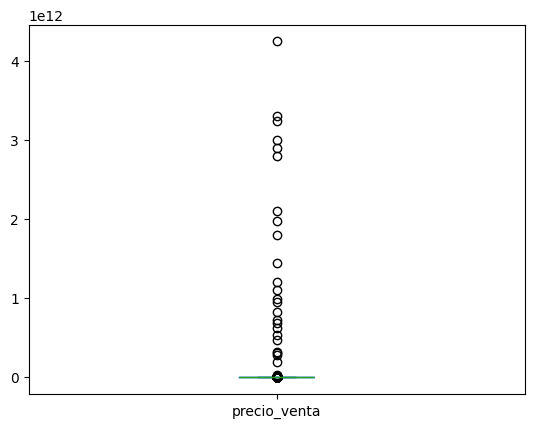

In [16]:
# Se detectan valores fuera de rango en la variable objetivo.
df_data["precio_venta"].plot.box()

Anotaciones sobre la variable objetivo:

La validación inicial mostró que la variable objetivo presenta una alta asimetría positiva, reflejando la presencia de valores atípicos extremos. En los ejercicios posteriores se evidenció que estos valores atípicos distorsionaban la métrica generales del modelo, afectando la calidad de las estimaciones.
Por esta razón, se tomó la decisión de filtrar dichos valores antes de la construcción del dataset final.

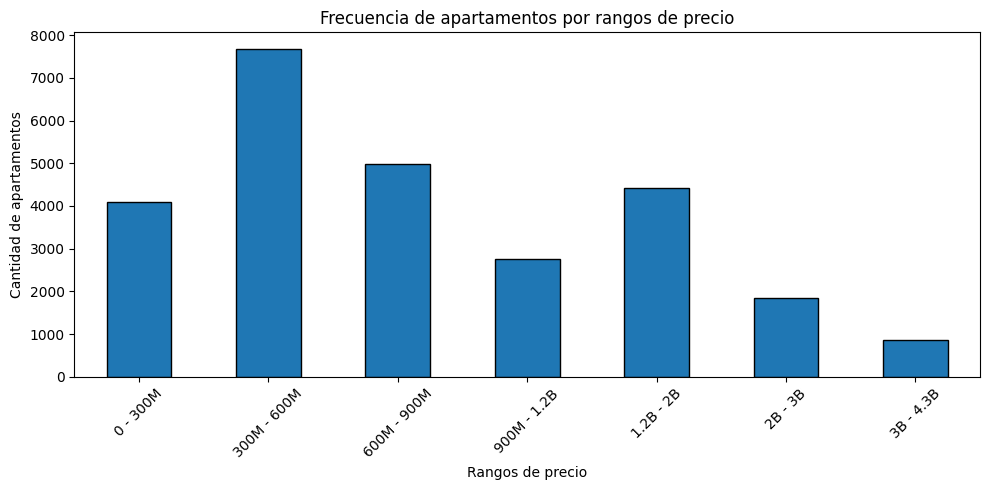

In [17]:
precios = df_data["precio_venta"]

# Definir los rangos (último = 4.1 billones)
bins = [0, 300_000_000, 600_000_000, 900_000_000, 1_200_000_000,2_000_000_000,3_000_000_000, 4_300_000_000]

# Etiquetas de los rangos
labels = [
    "0 - 300M",
    "300M - 600M",
    "600M - 900M",
    "900M - 1.2B",
    "1.2B - 2B",
    "2B - 3B",
    "3B - 4.3B"
]

# Cortar los datos según los rangos definidos
df_data["rango_precio"] = pd.cut(precios, bins=bins, labels=labels, include_lowest=True)

# Contar frecuencias por rango
frecuencias = df_data["rango_precio"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 5))
frecuencias.plot(kind="bar", edgecolor="black")

plt.title("Frecuencia de apartamentos por rangos de precio")
plt.xlabel("Rangos de precio")
plt.ylabel("Cantidad de apartamentos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La variable objetivo precio_venta presenta un valor de simetría de 52, lo que indica una fuerte asimetría positiva. Al analizar la gráfica de frecuencias, se observa que en los rangos de precios entre 2.000 millones y 4.300 millones hay menos apartamentos que los rangos de menor precio. Debido a esta baja representatividad en los valores extremos, se decidió filtrar el análisis a los apartamentos con precio de venta inferior a 2.000 millones, con el fin de trabajar con una distribución más estable y representativa del mercado.

In [18]:
df_data_2 = df_data[(df_data["precio_venta"] >= 10_000_000) & (df_data["precio_venta"] < 2_000_000_000)]

C:\Users\suare\AppData\Local\Temp\ipykernel_28816\2015664417.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2["rango_precio"] = pd.cut(precios, bins=bins, labels=labels, include_lowest=True)


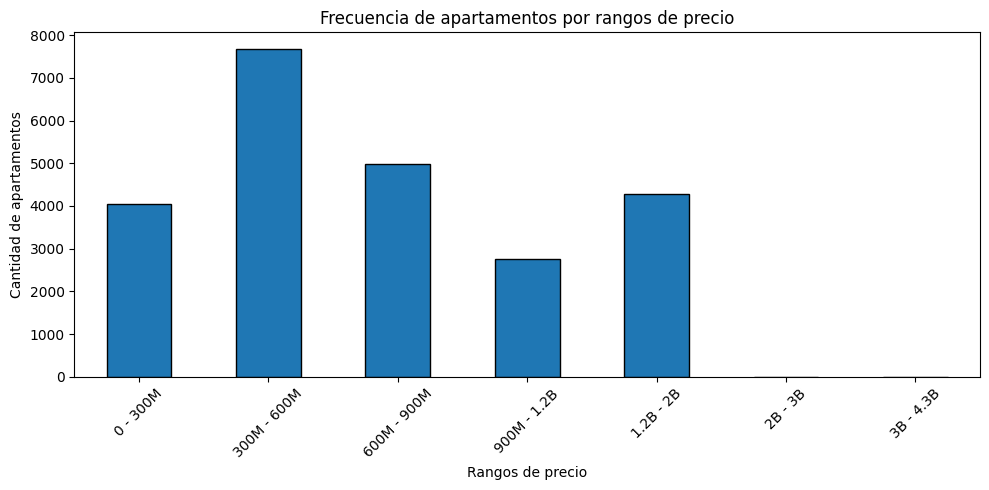

In [19]:
precios = df_data_2["precio_venta"]

# Definir los rangos (último = 4.1 billones)
bins = [0, 300_000_000, 600_000_000, 900_000_000, 1_200_000_000,2_000_000_000,3_000_000_000, 4_300_000_000]

# Etiquetas de los rangos
labels = [
    "0 - 300M",
    "300M - 600M",
    "600M - 900M",
    "900M - 1.2B",
    "1.2B - 2B",
    "2B - 3B",
    "3B - 4.3B"
]

# Cortar los datos según los rangos definidos
df_data_2["rango_precio"] = pd.cut(precios, bins=bins, labels=labels, include_lowest=True)

# Contar frecuencias por rango
frecuencias = df_data_2["rango_precio"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 5))
frecuencias.plot(kind="bar", edgecolor="black")

plt.title("Frecuencia de apartamentos por rangos de precio")
plt.xlabel("Rangos de precio")
plt.ylabel("Cantidad de apartamentos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df_data_2.describe()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,latitud,longitud,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,is_cerca_estacion_tm,distancia_parque_m,is_cerca_parque
count,23762.00,23762.00,23762.00,23762.00,21736.00,23762.00,23761.00,23762.00,23762.00,67.00,23760.00,0.00,0.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23762.00,23762.00,23762.00,23762.00
mean,740848182.71,118.23,2.66,2.61,4131650.37,1.54,4.71,4.69,-74.07,3856089.55,0.03,NaN,NaN,0.00,0.00,0.30,0.64,0.43,0.09,0.00,0.00,0.58,1242.01,0.22,820.08,0.25
std,465229613.79,234.36,0.76,1.05,60501717.75,0.95,1.22,0.04,0.04,2468348.35,0.18,NaN,NaN,0.00,0.00,0.46,0.48,0.50,0.29,0.00,0.04,0.49,843.82,0.42,432.04,0.44
min,19900000.00,0.00,1.00,0.00,1.00,-2.00,0.00,4.47,-74.21,740000.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.94,0.00,0.22,0.00
25%,376000095.00,65.00,2.00,2.00,314000.00,1.00,4.00,4.67,-74.07,1875000.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,549.22,0.00,495.73,0.00
50%,620000000.00,97.00,3.00,2.00,560000.00,2.00,5.00,4.70,-74.05,3500000.00,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1111.61,0.00,774.25,0.00
75%,1000000000.00,150.00,3.00,3.00,957000.00,2.00,6.00,4.72,-74.04,5500000.00,0.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1708.59,0.00,1095.71,1.00
max,1999990000.00,19621.00,7.00,6.00,2400000000.00,30.00,6.00,4.82,-74.02,12000000.00,1.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,7095.66,1.00,5865.30,1.00


Al aplicar el filtro a la variable objetivo precio_venta, el coeficiente de asimetría disminuye de 52 a menos de 1, lo cual indica una distribución mucho más equilibrada. Un valor de asimetría cercano a cero sugiere que la variable se aproxima a una distribución aproximadamente normal, mejorando así la calidad estadística del conjunto de datos para el modelado.

<Axes: xlabel='precio_venta', ylabel='Count'>

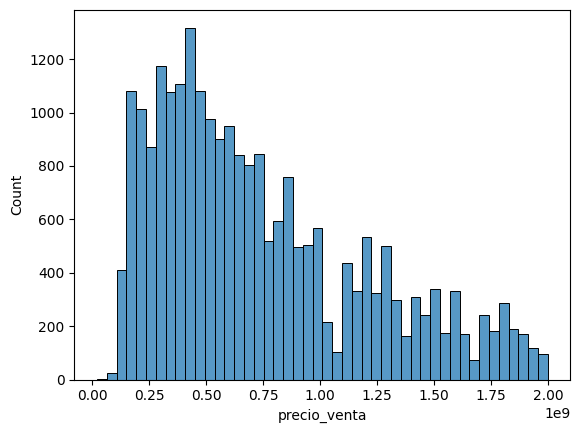

In [21]:
# Se valida nueva simétria
sns.histplot(df_data_2["precio_venta"])

In [22]:
df_data_2["precio_venta"].skew()

np.float64(0.8336417811178967)

<Axes: >

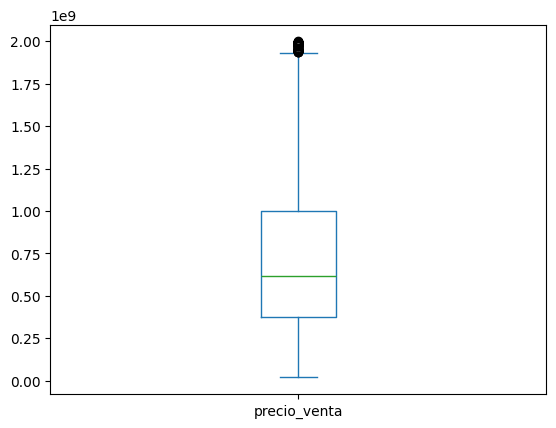

In [23]:
df_data_2["precio_venta"].plot.box()

In [24]:
df_cat = df_data_2.select_dtypes(include=["object"])
df_num = df_data_2.select_dtypes(include=["float64"])

In [25]:
df_num.skew()

precio_venta               0.83
area                      50.16
habitaciones              -0.52
banos                      0.47
administracion            21.21
parqueaderos               1.35
estrato                   -0.52
latitud                   -0.79
longitud                  -1.64
precio_arriendo            0.91
jacuzzi                    5.06
piso                        NaN
closets                     NaN
chimenea                   0.00
permite_mascotas           0.00
gimnasio                   0.89
ascensor                  -0.60
conjunto_cerrado           0.27
piscina                    2.85
salon_comunal              0.00
terraza                   26.38
vigilancia                -0.33
distancia_estacion_tm_m    1.21
distancia_parque_m         0.83
dtype: float64

In [26]:
df_num["precio_arriendo"].describe()

count         67.00
mean     3856089.55
std      2468348.35
min       740000.00
25%      1875000.00
50%      3500000.00
75%      5500000.00
max     12000000.00
Name: precio_arriendo, dtype: float64

In [27]:
df_num["estrato"].value_counts(dropna=False)

estrato
6.00    8605
4.00    5702
5.00    5100
3.00    3364
2.00     916
1.00      71
0.00       3
NaN        1
Name: count, dtype: int64

In [28]:
df_num.sort_values(by="administracion", ascending=False)

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,latitud,longitud,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,distancia_parque_m
9512,1700000000.00,200.00,3.00,4.00,2400000000.00,2.00,6.00,4.69,-74.03,NaN,0.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,2507.55,1959.28
22606,1390000000.00,214.00,2.00,3.00,1900000000.00,2.00,4.00,4.65,-74.06,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,574.74,729.62
1397,1300000000.00,190.00,3.00,3.00,1710000000.00,2.00,6.00,4.69,-74.05,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,606.28,1152.89
2214,1600000000.00,240.00,3.00,5.00,1650000000.00,3.00,6.00,4.72,-74.08,NaN,1.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,586.26,1083.45
24893,1150000000.00,135.00,3.00,2.00,1600000000.00,0.00,6.00,4.68,-74.05,NaN,0.00,NaN,NaN,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1229.81,1144.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42939,180437781.00,40.00,2.00,1.00,NaN,1.00,3.00,4.65,-74.15,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2212.95,1356.96
42952,192989691.00,56.00,3.00,2.00,NaN,0.00,2.00,4.63,-74.17,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,296.01,696.79
42961,292324830.00,46.00,2.00,1.00,NaN,0.00,3.00,4.67,-74.14,NaN,0.00,NaN,NaN,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2216.06,191.74
42984,1700000000.00,240.00,4.00,5.00,NaN,3.00,6.00,4.71,-74.04,NaN,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1493.36,428.92


En la validación de la simetría de las variables se evidenció que, tanto en Área como en Administración, son variables altamente asimétricas, con valores de skewness superiores a 2, lo cual indica la presencia de valores extremos que distorsionan la distribución.
Para mitigar este impacto, se procede a imputar la mediana para aquellos registros que se encuentran por fuera de los rangos intercuartílicos (IQR) y para valores nulos.

In [29]:
median_columns_1 = ["area"]
median_columns_2 = ["administracion"]

In [30]:
for i in median_columns_1:

    df_data_2.loc[:, i] = df_data_2[i].fillna(df_data_2[i].mean())
    
    Q1 = df_data_2[i].quantile(0.25)
    Q3 = df_data_2[i].quantile(0.75)

    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    df_data_2.loc[:, i] = np.where(
                            (df_data_2[i] < limite_inferior) | (df_data_2[i] > limite_superior),
                            df_data_2[i].mean(),
                            df_data_2[i]
    )

In [31]:
for i in median_columns_2:

    df_data_2.loc[:, i] = df_data_2[i].fillna(df_data_2[i].mean())
    
    Q1 = df_data_2[i].quantile(0.25)
    Q3 = df_data_2[i].quantile(0.75)

    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    df_data_2.loc[:, i] = np.where(
                            (df_data_2[i] < 50_000) | (df_data_2[i] > limite_superior),
                            df_data_2[i].mean(),
                            df_data_2[i]
    )

In [32]:
df_data_2["administracion"].mean()

np.float64(1045305.0637371488)

In [33]:
df_data_2.describe()

,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,latitud,longitud,precio_arriendo,jacuzzi,piso,closets,chimenea,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,piscina,salon_comunal,terraza,vigilancia,distancia_estacion_tm_m,is_cerca_estacion_tm,distancia_parque_m,is_cerca_parque
count,23762.00,23762.00,23762.00,23762.00,23762.00,23762.00,23761.00,23762.00,23762.00,67.00,23760.00,0.00,0.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23760.00,23762.00,23762.00,23762.00,23762.00
mean,740848182.71,109.69,2.66,2.61,1045305.06,1.54,4.71,4.69,-74.07,3856089.55,0.03,NaN,NaN,0.00,0.00,0.30,0.64,0.43,0.09,0.00,0.00,0.58,1242.01,0.22,820.08,0.25
std,465229613.79,56.32,0.76,1.05,1156773.36,0.95,1.22,0.04,0.04,2468348.35,0.18,NaN,NaN,0.00,0.00,0.46,0.48,0.50,0.29,0.00,0.04,0.49,843.82,0.42,432.04,0.44
min,19900000.00,0.00,1.00,0.00,50000.00,-2.00,0.00,4.47,-74.21,740000.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.94,0.00,0.22,0.00
25%,376000095.00,65.00,2.00,2.00,350000.00,1.00,4.00,4.67,-74.07,1875000.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,549.22,0.00,495.73,0.00
50%,620000000.00,97.00,3.00,2.00,636000.00,2.00,5.00,4.70,-74.05,3500000.00,0.00,NaN,NaN,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1111.61,0.00,774.25,0.00
75%,1000000000.00,145.00,3.00,3.00,1145000.00,2.00,6.00,4.72,-74.04,5500000.00,0.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1708.59,0.00,1095.71,1.00
max,1999990000.00,277.00,7.00,6.00,4131650.37,30.00,6.00,4.82,-74.02,12000000.00,1.00,NaN,NaN,0.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,7095.66,1.00,5865.30,1.00


En el análisis de variables se identificaron valores que no corresponden a la naturaleza de la variable, por ejemplo: apartamentos con baños en valores negativos o parqueaderos con cantidades negativas.
Con el fin de mejorar la calidad de estas variables, se procedió a ajustar dichos valores para garantizar coherencia y consistencia en el dataset.

In [34]:
df_data_2.loc[:, "banos"] = df_data_2["banos"].replace(0,1)

In [35]:
df_data_2.loc[:,"parqueaderos"] = np.where(df_data_2["parqueaderos"] < 0, 0, df_data_2["parqueaderos"])

In [36]:
df_data_2.loc[:, "estrato"] = df_data_2["estrato"].fillna(1)

In [37]:
df_data_2[df_num.columns].skew()

precio_venta               0.83
area                       0.79
habitaciones              -0.52
banos                      0.48
administracion             1.94
parqueaderos               1.35
estrato                   -0.53
latitud                   -0.79
longitud                  -1.64
precio_arriendo            0.91
jacuzzi                    5.06
piso                        NaN
closets                     NaN
chimenea                   0.00
permite_mascotas           0.00
gimnasio                   0.89
ascensor                  -0.60
conjunto_cerrado           0.27
piscina                    2.85
salon_comunal              0.00
terraza                   26.38
vigilancia                -0.33
distancia_estacion_tm_m    1.21
distancia_parque_m         0.83
dtype: float64

In [38]:
df_data_2["distancia_estacion_tm_m"].value_counts(dropna=False)

distancia_estacion_tm_m
749.49     36
21.45      24
359.11     22
2565.26    20
1399.92    20
           ..
768.67      1
574.40      1
1115.53     1
1252.46     1
823.67      1
Name: count, Length: 16238, dtype: int64

Construcción de las variables a utilizar.

In [39]:
num_columns = ["amenidades","latitud","longitud","precio_venta","area","habitaciones","banos","administracion","parqueaderos","estrato","distancia_estacion_tm_m","distancia_parque_m","antiguedad_nueva"]
cat_columns = ["sector_simplificado","compañia_simplificado","localidad"]

In [40]:
amenidades=["jacuzzi", "closets", "chimenea", "gimnasio", "ascensor", "conjunto_cerrado", "piscina", "salon_comunal", "vigilancia"]
df_data_2[amenidades] = df_data_2[amenidades].fillna(0).astype(int)
df_data_2['amenidades']=df_data_2[amenidades].sum(axis=1)

C:\Users\suare\AppData\Local\Temp\ipykernel_28816\722177745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2[amenidades] = df_data_2[amenidades].fillna(0).astype(int)
C:\Users\suare\AppData\Local\Temp\ipykernel_28816\722177745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2['amenidades']=df_data_2[amenidades].sum(axis=1)


In [41]:
mapa_orden = {
    "SOBRE PLANOS": 0,
    "EN CONSTRUCCION": 1,
    "PARA ESTRENAR": 2,
    "ENTRE 0 Y 5 ANOS": 3,
    "ENTRE 5 Y 10 ANOS": 4,
    "ENTRE 10 Y 20 ANOS": 5,
    "MAS DE 20 ANOS": 6,
    "REMODELADO": 7,
}
df_data_2.loc[:,"antiguedad_nueva"] = df_data_2["antiguedad"].map(mapa_orden)

C:\Users\suare\AppData\Local\Temp\ipykernel_28816\1774636912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2.loc[:,"antiguedad_nueva"] = df_data_2["antiguedad"].map(mapa_orden)


In [42]:
df_data_2.loc[:, "antiguedad_nueva"] = df_data_2["antiguedad_nueva"].fillna(0)

In [43]:
df_data_2.loc[:, "compañia"] = df_data_2["compañia"].fillna("NUEVA")

In [44]:
df_data_2[df_cat.columns].columns

Index(['_id', 'codigo', 'tipo_propiedad', 'tipo_operacion', 'sector',
       'antiguedad', 'direccion', 'descripcion', 'website', 'last_view',
       'datetime', 'url', 'timeline', 'estado', 'compañia', 'localidad',
       'barrio', 'estacion_tm_cercana', 'parque_cercano'],
      dtype='object')

In [45]:
frecuencias = df_data_2['sector'].value_counts()
umbral = 300

df_data_2.loc[:,'sector_simplificado'] = df_data_2['sector'].apply(
    lambda x: x if pd.notna(x) and frecuencias.get(x, 0) >= umbral else 'OTROS'
)

C:\Users\suare\AppData\Local\Temp\ipykernel_28816\2587395920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2.loc[:,'sector_simplificado'] = df_data_2['sector'].apply(


In [46]:
frecuencias = df_data_2['compañia'].value_counts()
umbral = 300

df_data_2.loc[:,'compañia_simplificado'] = df_data_2['compañia'].apply(
    lambda x: x if pd.notna(x) and frecuencias.get(x, 0) >= umbral else 'OTRO'
)

C:\Users\suare\AppData\Local\Temp\ipykernel_28816\1295048852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_2.loc[:,'compañia_simplificado'] = df_data_2['compañia'].apply(


In [47]:
df_data_2["compañia_simplificado"].value_counts()

compañia_simplificado
OTRO                                                              17012
NUEVA                                                              2747
ENGEL & VOLKERS                                                     766
CENTRO DE NEGOCIOS INMOBILIARIOS KELLER WILLIAMS SANTA ANA SAS      494
INMOBILIARE - JULIO CORREDOR                                        463
PADS                                                                453
REMAX COLOMBIA                                                      419
BRIKSS SAS                                                          384
RENTKASA                                                            374
CASA 360                                                            346
SAMM COLOMBIA                                                       304
Name: count, dtype: int64

In [48]:
df_data_3 = df_data_2[num_columns+cat_columns]

In [49]:
df_data_3[0:3]

,amenidades,latitud,longitud,precio_venta,area,habitaciones,banos,administracion,parqueaderos,estrato,distancia_estacion_tm_m,distancia_parque_m,antiguedad_nueva,sector_simplificado,compañia_simplificado,localidad
0,1,4.75,-74.06,339000000.00,76.00,3.00,2.00,300000.00,1.00,3.00,1142.45,426.09,5.00,OTROS,NUEVA,SUBA
1,0,4.73,-74.03,223000000.00,63.00,3.00,2.00,4131650.37,0.00,3.00,2384.89,472.47,6.00,OTROS,NUEVA,USAQUEN
2,1,4.61,-74.08,440898168.00,54.00,3.00,2.00,305000.00,0.00,3.00,232.22,961.29,3.00,OTROS,NUEVA,LOS MARTIRES


In [50]:
print(df_data_3[num_columns].corr(numeric_only=True)['precio_venta'].apply(lambda x: f"{x:.8f}"))

amenidades                 0.19710743
latitud                    0.00550276
longitud                   0.42809594
precio_venta               1.00000000
area                       0.84627225
habitaciones               0.32521301
banos                      0.75286563
administracion             0.26487520
parqueaderos               0.74099365
estrato                    0.68936813
distancia_estacion_tm_m    0.01324244
distancia_parque_m         0.11433282
antiguedad_nueva           0.12023782
Name: precio_venta, dtype: object


Durante el análisis se identificó que las variables Sector y Compañía presentan alta cardinalidad, es decir, contienen un número elevado de categorías distintas. Para evitar dispersión excesiva y mejorar la calidad del modelado, se definió un umbral de 300 apariciones. A partir de este criterio, todas las categorías cuya frecuencia es inferior a 300 registros fueron agrupadas en una nueva categoría denominada "OTROS".

Una vez realizados los ajustes sobre las variables con alta asimetría y alta cardinalidad, procedemos a separar la variable objetivo del conjunto de datos para iniciar los procesos de división del dataset, transformaciones, entrenamiento y construcción del modelo.

# Punto 2: Entrenamiento del modelo ML

In [51]:
X = df_data_3.drop(columns=["precio_venta"])
y = df_data_3["precio_venta"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include="number").columns.tolist()

In [54]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = pd.DataFrame(
    ohe.fit_transform(X_train[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    ohe.transform(X_test[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_test.index
)

In [55]:
scaler = StandardScaler()

X_train_num = pd.DataFrame(
    scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)

X_test_num = pd.DataFrame(
    scaler.transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index
)

In [56]:
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [57]:
model = LinearRegression()
model.fit(X_train_final, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Modelo Regresión Lineal

In [58]:
y_pred = model.predict(X_test_final)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²  :", r2_score(y_test, y_pred))

MAE : 130469272.82349074
RMSE: 185109711.69649866
R²  : 0.8390225144958561


Para la primera fase del experimento se empleó un modelo de regresión lineal. Las métricas de desempeño obtenidas fueron: un MAE de aproximadamente 130 millones, un RMSE de 185 millones y un R² de 0.83, lo que indica que, aunque el modelo captura una parte significativa de la variabilidad del precio de venta, pero aún presenta errores absolutos relativamente altos.

### Modelo Random Forest

- n_estimators (200–300): indica la cantidad de árboles de decisión que conforman el bosque.
- max_depth (None, 10, 20): controla la profundidad máxima de cada árbol. 
- min_samples_split (2–5): determina el número mínimo de muestras requerido para dividir un nodo interno. 
- min_samples_leaf (1–2): establece la cantidad mínima de muestras necesarias para que un nodo sea considerado hoja.

In [66]:
param_grid_rf = {
    'n_estimators': [300, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=4,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_final, y_train)

print("🌲 Mejor configuración Random Forest:")
print(grid_rf.best_params_)
print(f"Mejor MAE (train CV): {grid_rf.best_score_:.3f}")

Fitting 4 folds for each of 24 candidates, totalling 96 fits
🌲 Mejor configuración Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor MAE (train CV): -83420620.227


### Modelo XGB Regressor

Para la construcción del modelo se utilizó un XGBRegressor, evaluando un conjunto de hiperparámetros orientados a optimizar el desempeño y la capacidad de generalización.
Los hiperparámetros considerados en la búsqueda fueron:

- n_estimators: 500 y 700 (cantidad de árboles a entrenar)
- learning_rate: 0.05 y 0.1 (tasa de aprendizaje para controlar la contribución de cada árbol)
- max_depth: 9, 11 y 13 (profundidad máxima para controlar la complejidad del modelo)
- subsample: 0.8 y 1 (porcentaje de muestras utilizado por árbol)
- colsample_bytree: 0.8 y 1 (proporción de características utilizadas por árbol)

In [67]:
param_grid_xgb = {
    'n_estimators': [500, 700],
    'learning_rate': [0.05, 0.1],
    'max_depth': [9, 11, 13],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBRegressor(random_state=42)

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=4,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_final, y_train)

print("⚡ Mejor configuración XGBoost:")
print(grid_xgb.best_params_)
print(f"Mejor MAE (train CV): {grid_xgb.best_score_:.3f}")

Fitting 4 folds for each of 48 candidates, totalling 192 fits
⚡ Mejor configuración XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 700, 'subsample': 0.8}
Mejor MAE (train CV): -79798311.072


In [68]:
# Modelos optimizados
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_

# Predicciones
rf_pred = best_rf.predict(X_test_final)
xgb_pred = best_xgb.predict(X_test_final)

# Métricas
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📊 {nombre_modelo}")
    print(f"RMSE: {rmse:,.0f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.3f}")

evaluar_modelo(y_test, rf_pred, "Random Forest (Optimizado)")
evaluar_modelo(y_test, xgb_pred, "XGBoost (Optimizado)")


📊 Random Forest (Optimizado)
RMSE: 134,345,270
R²: 0.915
MAE: 82462036.620

📊 XGBoost (Optimizado)
RMSE: 128,373,786
R²: 0.923
MAE: 78278652.758


In [69]:
error_relativo = np.abs(y_test - xgb_pred) / y_test
error_relativo_prom = error_relativo.mean()

print("Error relativo promedio:", error_relativo_prom)
print("Error relativo promedio (%):", error_relativo_prom * 100)

Error relativo promedio: 0.12206683661808466
Error relativo promedio (%): 12.206683661808466


# Punto 3: Análisis Cuantitativo del modelo


XGBoost obtuvo el mejor rendimiento frente a Regresión Lineal y Random Forest debido a su capacidad para capturar relaciones no lineales, manejar interacciones complejas y ser más robusto ante outliers.

Métricas principales

- R² = 92% → Explica la mayor parte de la variabilidad del precio de venta.
- MAE ≈ 78M COP → Error promedio aceptable (~12%) para modelos inmobiliarios.
- RMSE ≈ 128M COP → Indica la presencia de algunos casos extremos con errores altos.

Transformaciones clave que mejoraron el desempeño

- Variable “amenidades”: consolidación de 10 atributos en uno solo.
- Antigüedad ordinal: representación monotónica más consistente.
- Agrupación de sectores: reducción de cardinalidad y overfitting.
- Corrección de asimetría en área y administración.
- Ajuste de la variable objetivo mediante análisis de distribución.

Oportunidades de mejora

- Enfocar ajustes en inmuebles atípicos, ya que los errores altos elevan el RMSE.
- Considerar segmentar modelos por rangos de precio (bajo precio, medio, alto precio) o aplicar transformaciones adicionales.

### Punto 4: Análisis cualitativo de resultados del modelo:

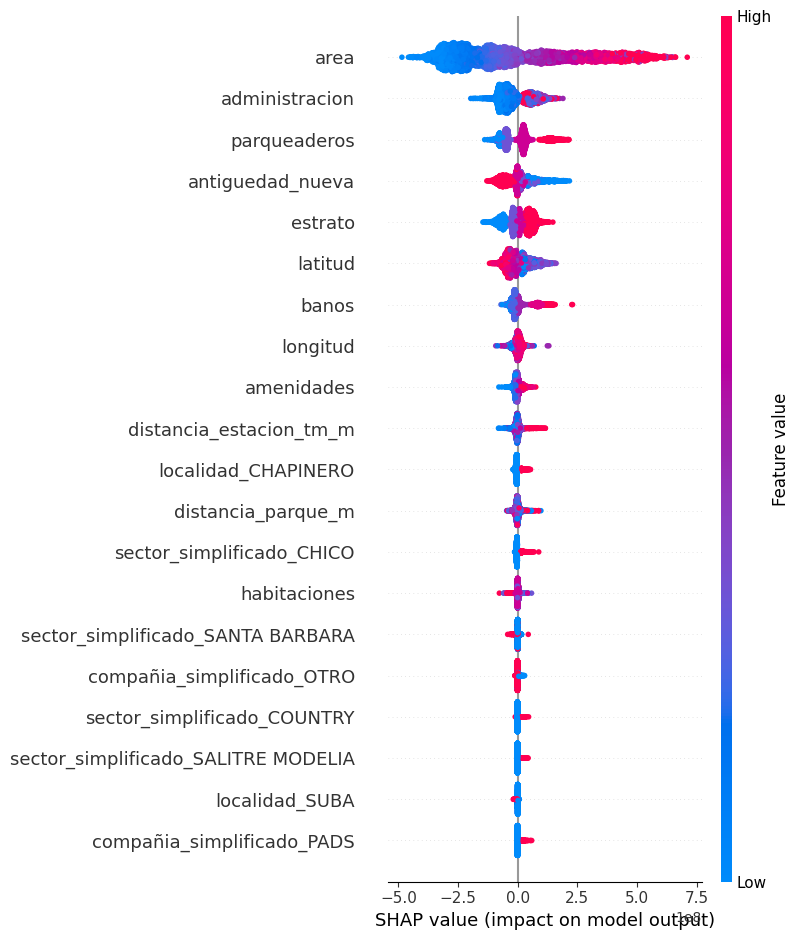

In [70]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_final)
shap.summary_plot(shap_values, X_test_final)

Las variables con mayor influencia en las predicciones son área, administración y parqueaderos, lo cual es coherente con el comportamiento del mercado inmobiliario.

- Área es la variable más determinante: inmuebles con mayor metraje presentan precios significativamente más altos, mientras que áreas pequeñas reducen el valor predicho.
- Administración también aporta un peso importante: valores elevados suelen estar asociadas a conjuntos más completos o zonas de mayor estrato, lo que se refleja en precios superiores.
- Parqueaderos tienen un impacto positivo: a mayor número de parqueaderos, mayor es el precio estimado del inmueble.
- Adicionalmente, variables como sector_simplificado_CHICO y localidad_CHAPINERO muestran valores SHAP mayormente positivos, indicando que pertenecer a estas zonas —entre las más valorizadas de la ciudad— incrementa el precio predicho.

En conjunto, el análisis SHAP confirma que el modelo está capturando adecuadamente las dinámicas del mercado, priorizando tamaño, costos de administración, parqueaderos y ubicación como los principales determinantes del valor del inmueble.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


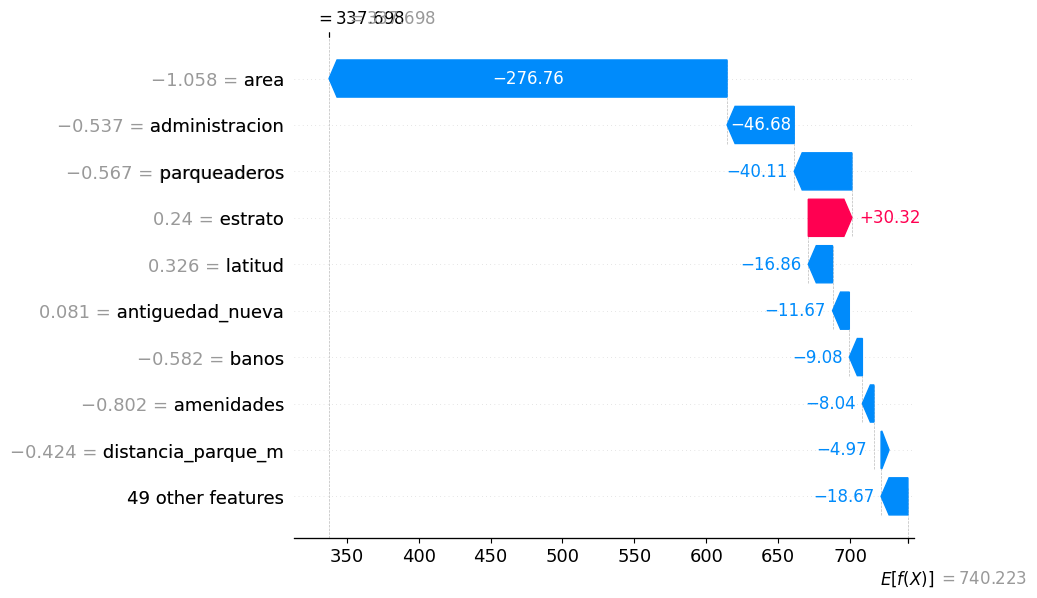

In [71]:
# Crear el explainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_test_final)
import matplotlib.ticker as ticker
# generar shap values normales

# escalar SHAP
factor = 1e6  # escala a millones

shap_values_scaled = shap.Explanation(
    values = shap_values.values.copy() / factor,
    base_values = shap_values.base_values.copy() / factor,
    data = shap_values.data.copy(),
    feature_names = shap_values.feature_names
)
# graficar un caso
i = 0
shap.plots.waterfall(shap_values_scaled[i])

La predicción final del modelo para este inmueble es de aproximadamente 337 millones aprox, partiendo de un valor promedio de 740 millones aprox.

La caída drástica en la predicción está dominada por el área (–276 millones aprox), seguida por el bajo valor de la administración (–46 millones aprox), el parqueadero (–40 millones aprox).

En conjunto, estas características explican por qué este inmueble se valora muy por debajo del promedio según el modelo.


===== Importancia Global LIME =====

area > 0.63                                         94229152.95
area <= -0.79                                       71847352.04
localidad_TUNJUELITO <= 0.00                        64167698.51
localidad_CANDELARIA <= 0.00                        58791202.75
estrato <= -0.58                                    58188505.41
                                                        ...    
compañia_simplificado_RENTKASA > 0.00                 164021.36
compañia_simplificado_REMAX COLOMBIA > 0.00           145942.38
sector_simplificado_CENTRO Y ZONA COLONIAL > 0.00      41882.40
localidad_RAFAEL URIBE URIBE > 0.00                    39282.57
sector_simplificado_CERROS DE SUBA > 0.00              28240.61
Length: 132, dtype: float64


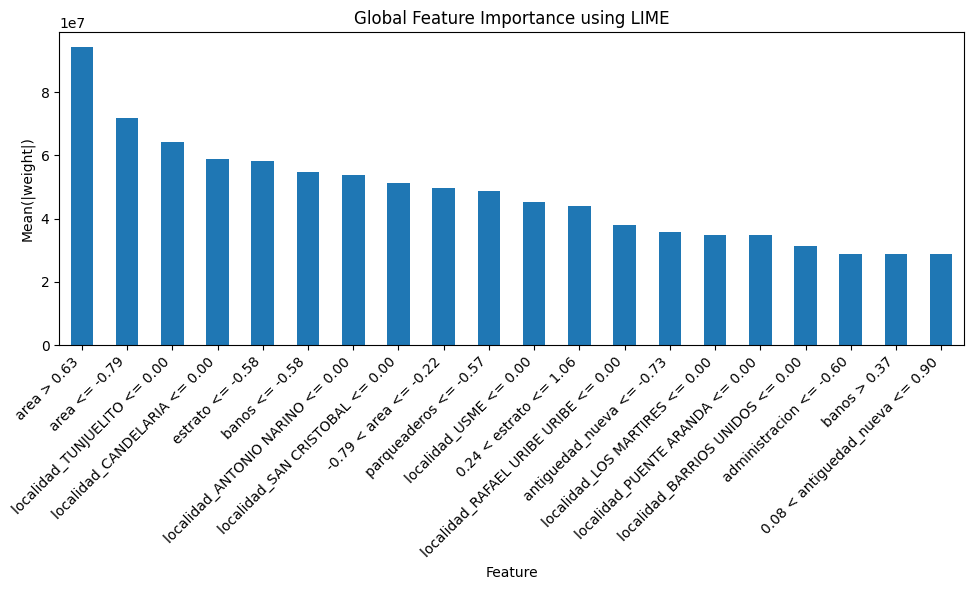

In [74]:
# 1. Crear el explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_final),
    feature_names=X_train_final.columns,
    mode="regression"
)

# 2. Número de muestras que vamos a explicar
n_samples = 200

# 3. Guardar resultados
all_weights = []

for i in range(n_samples):
    idx = np.random.randint(0, X_test_final.shape[0])
    instance = X_test_final.iloc[idx].values

    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=best_xgb.predict,
        num_features=len(X_train_final.columns)
    )
    
    # extraemos pares (feature, weight)
    local_weights = dict(exp.as_list())
    all_weights.append(local_weights)

# 4. Convertimos a DataFrame
df_importance = pd.DataFrame(all_weights).fillna(0)

# 5. Importancia global = promedio del valor absoluto
global_importance = df_importance.abs().mean().sort_values(ascending=False)

print("\n===== Importancia Global LIME =====\n")
print(global_importance)

# 6. Graficar la importancia global
plt.figure(figsize=(10,6))
global_importance.head(20).plot(kind='bar')
plt.title("Global Feature Importance using LIME")
plt.ylabel("Mean(|weight|)")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

LIME muestra que el modelo se apoya principalmente en el área, el estrato y la ubicación geográfica para predecir el precio de los inmuebles. El tamaño del inmueble es el factor dominante, seguido por las diferencias de estrato y la zona. Otras variables como baños, parqueaderos y antigüedad también contribuyen, pero en menor medida.

In [77]:
# 1. Crear el explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_final),
    feature_names=X_train_final.columns,
    class_names=['pred'],
    mode='regression'
)

# 2. Seleccionar el ejemplo a explicar (cambia el índice)
i = 0
instance = X_test_final.iloc[i]

# 3. Generar explicación local
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=best_xgb.predict,
    num_features=len(X_train_final.columns)
)

# 4. Mostrar los sustitutos locales (coeficientes del modelo lineal)
local_surrogate = exp.local_exp[0]
local_surrogate_df = pd.DataFrame([
    (X_train_final.columns[idx], weight)
    for idx, weight in local_surrogate
], columns=["feature", "peso_local"])

local_surrogate_df

C:\Users\suare\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\suare\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\suare\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

,feature,peso_local
0,area,308110534.46
1,localidad_CANDELARIA,188390885.49
2,banos,108322034.29
3,parqueaderos,95096935.60
4,localidad_RAFAEL URIBE URIBE,90113712.11
5,localidad_LOS MARTIRES,74729722.08
6,localidad_ANTONIO NARINO,-52189706.30
7,administracion,50289181.32
8,sector_simplificado_SALITRE MODELIA,37696690.08
9,sector_simplificado_FONTIBON TINTAL,36531894.98


Para el inmueble analizado, la predicción del modelo está principalmente explicada por el área, los baños, los parqueaderos y algunas señales geográficas específicas. LIME confirma que características estructurales y de ubicación son determinantes para el valor estimado del inmueble, pero la explicación es local y válida únicamente para este registro, no para todo el modelo.

### Punto 5: Generación de valor

In [78]:
# Aca se obtiene la cantidad de subestimaciones 
# y sobre estimaciones que se infieren con base al dataset de prueba
df_resultados = pd.DataFrame({
    'valor_real': y_test.values,
    'prediccion': xgb_pred
})
df_resultados.index = y_test.index
print(df_resultados.describe())

         valor_real    prediccion
count       4753.00       4753.00
mean   743476418.49  745776896.00
std    461415655.67  443738816.00
min     19900000.00   91479768.00
25%    380000000.00  391918432.00
50%    630000000.00  635558016.00
75%    999000000.00 1047805312.00
max   1999990000.00 1977790976.00


In [79]:
df_resultados["diferencia_valor_real_valor_predicho"]= df_resultados["valor_real"] - df_resultados["prediccion"]
# encontrando los casos en donde se estimo el precio por debajo de 20 millones
df_subestimacion_critica = df_resultados[((df_resultados["diferencia_valor_real_valor_predicho"] > 20_000_000))]
print(df_subestimacion_critica.describe())

         valor_real    prediccion  diferencia_valor_real_valor_predicho
count       1506.00       1506.00                               1506.00
mean   996315511.75  880718784.00                          115596650.09
std    505733245.11  451833088.00                          111416698.83
min    176400000.00  155683472.00                           20003360.00
25%    570850000.00  498336464.00                           40246232.00
50%    895000000.00  802471488.00                           74643792.00
75%   1400000000.00 1216075584.00                          151066592.00
max   1999990000.00 1944741760.00                          841716208.00


In [80]:
# encontrando valores de subestimacion aceptable
df_subestimacion_aceptable= df_resultados[(df_resultados["diferencia_valor_real_valor_predicho"] <= 20_000_000)]
print(df_subestimacion_aceptable.describe())

         valor_real    prediccion  diferencia_valor_real_valor_predicho
count       3247.00       3247.00                               3247.00
mean   626206423.28  683189056.00                          -56982691.15
std    386886557.47  425718560.00                           94485810.55
min     19900000.00   91479768.00                        -1818428448.00
25%    330000000.00  351345168.00                          -77708256.00
50%    520000000.00  558877504.00                          -23683840.00
75%    850000000.00  942443616.00                            -864320.00
max   1980000000.00 1977790976.00                           19972448.00


In [81]:
# encontrando los casos en donde se sobreestimo el precio 
df_sobreestimacion= df_resultados[((df_resultados["valor_real"] < df_resultados["prediccion"] ))]
print(df_sobreestimacion.describe())

         valor_real    prediccion  diferencia_valor_real_valor_predicho
count       2482.00       2482.00                               2482.00
mean   661161848.84  738315904.00                          -77154045.06
std    387468917.94  428698496.00                           99711873.59
min     19900000.00   95334608.00                        -1818428448.00
25%    360000000.00  399523672.00                         -100685344.00
50%    560000000.00  636650016.00                          -43497216.00
75%    890000000.00  997815712.00                          -15005072.00
max   1900000000.00 1977790976.00                              -8832.00


##### Condiciones: 

- Salario por hora del perito = 9.500 COP/h
- Tiempo actual por estimación (manual) = 6 h
- Tiempo con modelo = 1 h
- Ahorro por estimación (horas): (6−1)×9.500=5×9.500= 47.500 COP.
- Volumen: N = 500 estimaciones/mes.
- Propiedades_sobreestimadas = (52.61%) → 2482 propiedades
- Propiedades_subestimadas_por_debajo_20_millones = 32% → 1506 propiedades
- Resto (≈16%) son subestimaciones ligeras o exactas → no visita.
- Costo adicional por avalúo presencial (asumido): 6 h del perito + gastos logísticos = 6×9.500 + 50.000 = 107.000 COP.
- Costo operativo mensual del modelo (hosting, MLOps, mantenimiento): 500.000 COP (supuesto).

Tarifas consultores senior

Según datos publicados por Toptal (s.f.), los consultores senior de ciencia de datos cobran entre USD 90 y 200 por hora, lo que ubica proyectos típicos entre USD 15.000 y 80.000. 

Toptal. (s.f.). Hire the Top 3% of Data Scientists. Recuperado el [2025-11-22], de https://www.toptal.com/data-science

- USD 90 - 200 por hora.
- Proyectos típicos de 150 - 400 horas.
- 90 * 150 = 13.500 USD * 3800 TRM = 51.300.000 COP

In [93]:
# Parámetros 
costo_perito_hora = 9500.0
t_manual = 6.0
t_model = 1.0
ahorro_por_uso_modelo = (t_manual - t_model) * costo_perito_hora

# cantidad de estimaciones por mes para el modelo
N = 500
p_visita = 0.3297
p_sobre = 0.5261

costo_extra_visita = 50000.0
cost_por_visita = 6 * costo_perito_hora + costo_extra_visita
costo_operacion_mensual = 500_000.0
costo_implementacion = 53_300_000.0

# Cálculos
A_teorico = ahorro_por_uso_modelo
A_esperado = A_teorico - p_visita * cost_por_visita
G_mensual = N * A_esperado
G_neto_mensual = G_mensual - costo_operacion_mensual
G_anual = G_neto_mensual * 12
visitas_esperadas = N * p_visita

def break_even_months(initial, monthly_net):
    return initial / monthly_net if monthly_net > 0 else float('inf')

print("Costo asociado a peritos para una revision de un inmueble:",costo_perito_hora*t_manual)
print("Ahorro teorico por estimación (COP):", round(ahorro_por_uso_modelo, 2))
print("Ahorro real por estimación (COP):", round(A_esperado, 2))
print("Costo de una estimacion asociado a los errores del modelo:", round(p_visita * cost_por_visita, 2))
print("Visitas esperadas/mes:", round(visitas_esperadas, 1))
print("Ganancia neta mensual (COP):", round(G_neto_mensual, 2))
print("Ganancia neta anual (COP):", round(G_anual, 2))
print("Break-even (meses) para 53M COP:", round(break_even_months(costo_implementacion, G_neto_mensual), 3))
print("ROI Anual (porcentaje): ", (G_anual/costo_implementacion)*100 )

Costo asociado a peritos para una revision de un inmueble: 57000.0
Ahorro teorico por estimación (COP): 47500.0
Ahorro real por estimación (COP): 12222.1
Costo de una estimacion asociado a los errores del modelo: 35277.9
Visitas esperadas/mes: 164.8
Ganancia neta mensual (COP): 5611050.0
Ganancia neta anual (COP): 67332600.0
Break-even (meses) para 53M COP: 9.499
ROI Anual (porcentaje):  126.32757973733581


### Resumen de Impacto Operativo y Financiero del Modelo de Valoración

• Retorno de inversión (ROI): 126%

Un ROI del 126% indica que por cada 1 COP invertido en el desarrollo e implementación del modelo, la empresa obtiene 1.26 COP adicionales como ganancia neta durante el primer año de operación.

• Punto de equilibrio (Break-even): 9.49 meses
La inversión inicial se recupera en aproximadamente 9.5 meses, lo cual confirma que el proyecto es altamente rentable en un horizonte anual.

### Factor crítico de riesgo

La métrica más importante a controlar es la tasa de subestimaciones mayores a 20M COP, actualmente en 32%.
Una subestimación grande representa riesgo de pérdida directa de oportunidades de compra por ofrecer un valor inferior al mercado real.

### Impacto Operativo: Ahorro sustancial de horas perito

Para un escenario de 500 visitas, el análisis muestra:

Sin modelo:

- 500 estimaciones * 6 horas = 3.000 horas perito

Con modelo:

- 340 casos exitosos * 1 hora = 340 horas
- 160 casos fallidos * 6 horas = 960 horas
- Total con modelo = 1.300 horas

Ahorro total:
- 3.000 horas − 1.300 horas = 1.700 horas

Esto equivale a una reducción del 56.6% del tiempo operativo requerido.
La capacidad liberada (1.700 horas) es el motor principal del beneficio económico.

Cómo se aprovecha la capacidad liberada

### El tiempo liberado permite que los peritos se enfoquen en tareas de mayor valor:

- Gestión prioritaria de las 160 visitas críticas (los casos donde el modelo no es suficiente).
- Análisis de mercado más profundos para mejorar la estrategia de compra.
- Gestión de oportunidades complejas que antes se descartaban por limitación de tiempo.

### Ventajas operativas adicionales

1. Velocidad de respuesta (TAT – Turnaround Time)

Reducir el tiempo por estimación de 6 horas a 1 hora hace que la empresa responda más rápido a clientes y logre capturar oportunidades que la competencia pierde por depender de procesos manuales.
Es una ventaja competitiva directa.

2. Identificación de oportunidades comerciales

El modelo revela que el 52.61% de las estimaciones actuales son sobreestimadas.
Aunque estos errores pasan desapercibidos para el cliente, implican un riesgo: ofrecer precios más altos de lo necesario.
Esta métrica es clave para ajustar la estrategia de pricing de compra.

3. Concentración eficiente de recursos

Los casos más delicados (160 al mes) pueden ser gestionados con mayor foco y calidad, porque el modelo filtra rápidamente los casos simples (340 al mes).
La gerencia obtiene claridad sobre dónde asignar el recurso más costoso: el perito.

### Resumen Ejecutivo

El modelo no solo es financieramente rentable (ROI 126%, break-even < 10 meses), sino que genera una transformación operativa significativa: mejora la velocidad de respuesta, optimiza el uso del recurso experto y habilita decisiones más precisas de compra, reduciendo errores críticos y fortaleciendo la estrategia comercial.